# Filtre de Kalman

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

## Preuve formules de récursion
On suppose le modèle suivant: 
\begin{align*}
X_k & = F X_{k-1} + U_k \\
Y_k & = H X_k + V_k 
\end{align*}
où $U_k \sim \mathcal{N}(0,Q)$ et $V_k \sim \mathcal{N}(0,R)$. On suppose que $X_{0} \sim \mathcal{N}(\mu_{0|0}, P_{0|0})$.


On s'intéresse au calcul des moments d'ordre 1 et de 2 de la densité de filtrage $p(x_k | y_{0:k})$, récursivement. On les note respectivement $\mu_{k|k}$ et $P_{k|k}$.

On admet la formule suivante:

$$ \int \mathcal{N}(y|Ax + b, L) \mathcal{N}(x|\mu, G) dx = \mathcal{N}(y|A\mu + b, L + AGA^T)$$ 


Commençons par remarquer que (en appliquant Bayes): 
$$ p(x_k | y_{0:k}) = \frac{g(y_k | x_k) p(x_k | y_{0:k-1})}{\int g(y_k | x_k) p(x_k | y_{0:k-1}) dx_k} $$ 
puis que: 
\begin{align*}
p(x_k | y_{0:k-1}) &= \int p(x_k, x_{k-1} | y_{0:k-1}) dx_{k-1} \\
& = \int p(x_k|x_{k-1})p(x_{k-1} | y_{0:k-1}) dx_{k-1}\\
& = \int \mathcal{N}(x_k |F x_{k-1}, Q) \mathcal{N}(x_{k-1} | \mu_{k-1|k-1}, P_{k-1|k-1}) dx_{k-1} \\
& = \mathcal{N}(x_k | F \mu_{k-1|k-1}, Q + F P_{k-1|k-1} F^T)
\end{align*}
et on note: $\mu_{k|k-1} = F\mu_{k-1|k-1}$ et $P_{k|k-1} = Q + F P_{k-1|k-1}F^T$. 

On peut à présent calculer $p(x_k | y_{0:k})$. Pour cela on utilise le résultat suivant: 
$$ \mathcal{N}(y|Hx, R) \mathcal{N}(x|m,P) =  q(y) \mathcal{N}(x | \hat{m}, \hat{P})$$ 

où:
\begin{align*}
\hat{m} & = m + K (y - Hm) \\
\hat{P} & = (I - KH)P \\
K & = PH^T(HPH^T + R)^{-1}
\end{align*}

Par conséquent: 
\begin{align*}
g(y_k | x_k) p(x_k | y_{0:k-1}) & \propto \mathcal{N}(y_k | Hx_k, R) \mathcal{N}(x_k | \mu_{k|k-1}, P_{k | k-1})\\
& \propto \mathcal{N}(x_k | \mu_{k|k}, P_{k|k})
\end{align*}
le terme $q(y)$
où: 

\begin{align*}
\mu_{k|k} & = \mu_{k|k-1} + K (y_k - H\mu_{k|k-1}) \\
P_{k|k} & = (I - KH)P_{k | k-1} \\
K & = P_{k|k-1} H^T(H P_{k|k-1} H^T + R)^{-1}
\end{align*}

## Quelques bonnes habitudes

In [91]:
A = np.array([[1,2,3],
              [4,5,6]])

B = np.ones([3,2])

In [83]:
# Utiliser A @ B au lieu de np.dot(A,B) pour faire un produit matriciel.
# Ne pas confondre avec A * B, qui est le produit élément par élément.
A @ B

array([[ 6.,  6.],
       [15., 15.]])

In [98]:
#faites attention aux tailles des matrices

v  = np.ones([3])
u = np.ones([3,1]) 

print(f"v : {v}")
print(f"u : \n{u}")

v : [1. 1. 1.]
u : 
[[1.]
 [1.]
 [1.]]


In [100]:
#transposer v ne résout pas le problème. v garde la même taille car c'est une matrice 1 dimension.

v.T

array([1., 1., 1.])

In [102]:
#pour changer la taille d'une matrice:
#Pas besoin de spécifier toutes les dimensions, elles sont inférées automatiquement.

v.reshape(-1,1)

array([[1.],
       [1.],
       [1.]])

In [115]:
#Selection de lignes ou colonnes

A = np.random.uniform(0,1,(3,5))

print(A)
A[1:,1:3]

[[0.38628201 0.53780417 0.15337222 0.97685801 0.05625183]
 [0.61631844 0.4437312  0.04890883 0.65868067 0.30164277]
 [0.96345214 0.54304983 0.88637741 0.3417406  0.39028701]]


array([[0.4437312 , 0.04890883],
       [0.54304983, 0.88637741]])

In [136]:
#Quand on selectionne une colonne, le résultat n'est pas une matrice colonne

A[:,3].reshape(-1,1)

array([[0.97685801],
       [0.65868067],
       [0.3417406 ]])

In [164]:
params = {'T_e': 1,
          'T': 100,
          'sigma_Q': 1,
          'sigma_px': 30,
          'sigma_py':30}

F = np.array([[1,params['T_e'],0,0],
              [0,1,0,0],
              [0,0,1,params['T_e']],
              [0,0,0,1]])

H = np.array([[1,0,0,0],[0,0,1,0]])

block = np.array([[params['T_e']**3 / 2, params['T_e']**2 / 2],
                  [params['T_e']**2 / 2, params['T_e']]])

Q = params['sigma_Q']**2 * np.block([[block, np.zeros([2,2])],[np.zeros([2,2]), block]])

R = np.array([[params['sigma_px']**2,0],
              [0,params['sigma_py']**2]])

x_init = np.array([[3,40,-4,20]]).reshape(-1,1)

In [171]:
def creer_trajectoire(F = F, Q = Q, x_init = x_init, T = params['T']):
    
    x_0_T = x_init
    
    for i in range(T-1):
        
        x_t = F @ x_0_T[:,-1].reshape(-1,1) + np.random.multivariate_normal(np.zeros([4]),Q).reshape(-1,1)
        x_0_T = np.hstack([x_0_T, x_t])
        
    return x_0_T
    
def creer_observations(vecteur_x, H = H, R = R, T = params['T']):
    
    y_0_T = H @ vecteur_x + np.random.multivariate_normal(np.zeros([2]), R, (vecteur_x.shape[1])).T
    
    return y_0_T



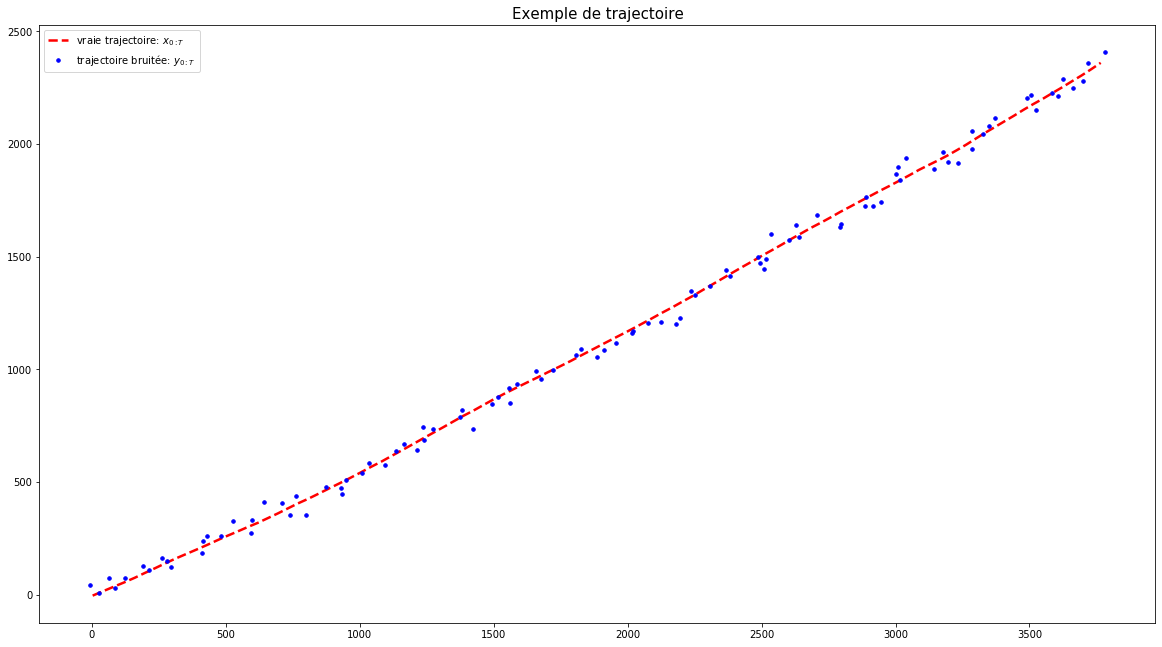

In [195]:
x_0_T = creer_trajectoire()
y_0_T = creer_observations(x_0_T)

plt.figure(figsize = (20,11))
plt.title('Exemple de trajectoire', fontsize = 15)
plt.plot(x_0_T[0], x_0_T[2], 'r--',linewidth = 2.5,label = 'vraie trajectoire: $x_{0:T}$')
plt.plot(y_0_T[0], y_0_T[1], 'bo',markersize = 3.5, label = 'trajectoire bruitée: $y_{0:T}$')
plt.legend()

In [173]:
def kalman_step(F, Q, H, R, y_k, x_kalm_prec, P_kalm_prec):
    """
    x_kalm_prec: mu_{k-1 | k-1}
    P_kalm_prec: P_{k-1 | k-1}
    """
    assert x_kalm_prec.shape[1] == 1
    
    #prediction step
    mu_k_k_1 = F @ x_kalm_prec
    P_k_k_1  = Q + F @ P_kalm_prec @ F.T
    
    #update step
    K = P_k_k_1 @ H.T @ np.linalg.inv(H @ P_k_k_1 @ H.T + R)
    
    mu_k_k = mu_k_k_1 + K @ (y_k - H @ mu_k_k_1)
    P_k_k  = (np.eye(P_k_k_1.shape[0]) - K @ H) @ P_k_k_1
    
    return mu_k_k, P_k_k

def kalman_filter(path,
                  observations,
                  F = F,
                  Q = Q,
                  H = H,
                  R = R):
    
    T = path.shape[1]
    
    mu_0_0 = path[:,0].reshape(-1,1)
    P_0_0  = np.eye(mu_0_0.shape[0])
    
    mu_ks = mu_0_0
    P_k   = P_0_0
    
    for t in range(T):
        
        mu_k, P_k = kalman_step(F,Q,H,R,
                                observations[:,t].reshape(-1,1),
                                mu_ks[:,-1].reshape(-1,1),
                                P_k)
        
        mu_ks = np.hstack([mu_ks, mu_k])
        
    return mu_ks
    

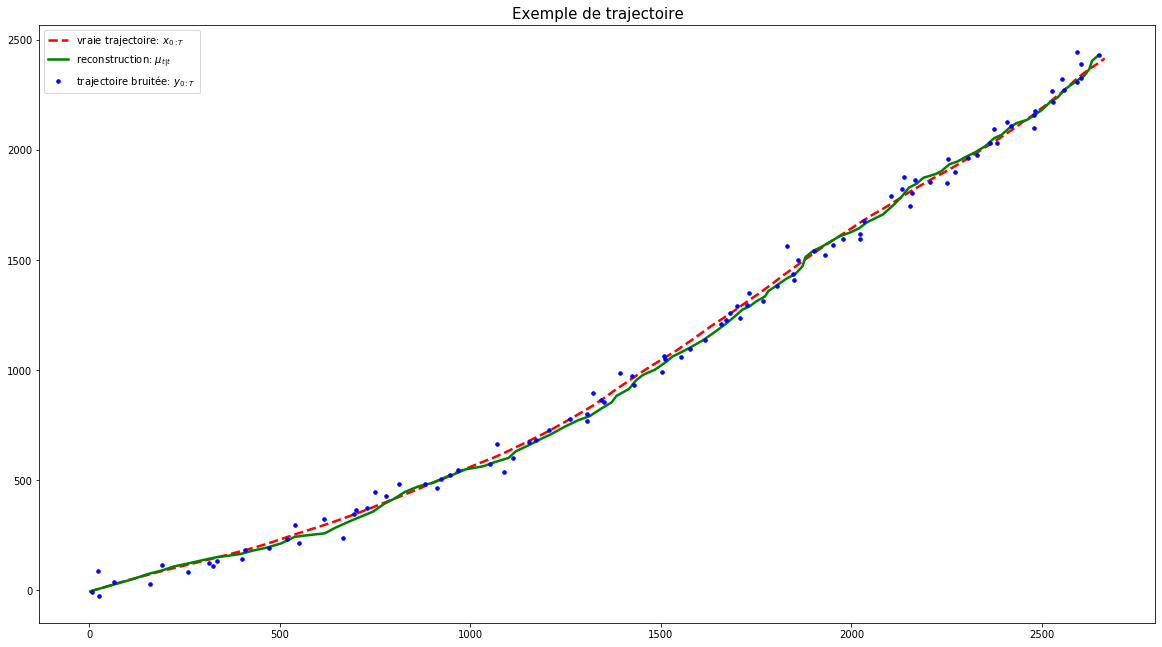

In [194]:
x_0_T = creer_trajectoire()
y_0_T = creer_observations(x_0_T)

est_x_0_T = kalman_filter(x_0_T, y_0_T)

plt.figure(figsize = (20,11))
plt.title('Exemple de trajectoire', fontsize = 15)
plt.plot(x_0_T[0], x_0_T[2], 'r--',linewidth = 2.5,label = 'vraie trajectoire: $x_{0:T}$')
plt.plot(est_x_0_T[0], est_x_0_T[2], 'g', linewidth = 2.5, label = 'reconstruction: $\mu_{t|t}$')
plt.plot(y_0_T[0], y_0_T[1], 'bo',markersize = 3.5, label = 'trajectoire bruitée: $y_{0:T}$')
plt.legend()